[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/GradientDescent.ipynb)

# Gradient Descent
Given we can calculate the gradient of our cost function, we can minimize it by moving in the opposite direction of the gradient using some learning rate. You already saw a minimal implementation of this for the `fit` function in `LogisticRegression`. Here, we want to try different Gradient Descent methods, by implementing them independently of the underlying model. This way we can simply pass a `gradient()` function to the **optimizer** and ask it to find the optimal set of parameters for our model -- that is we don't need a specialized implementation say for `LinearRegression` and `LogisticRegression`. While there are different ways we could have a separate optimizer, here, we define an optimizer class -- such as `StochasticGradientDescent` -- and pass an instance of this class to the `fit` function for our model. The `fit` function could then `run` the optimizer to fit the data. Here, we only implement the vanilla `GradientDescent` class.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [2]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        """
        Initialize Gradient Descent optimizer.
        
        This optimizer can be used with any model that provides a gradient function.
        It iteratively updates parameters by moving in the opposite direction of the gradient.
        
        Parameters:
        learning_rate: step size for each iteration (also called alpha)
                      - too small: slow convergence
                      - too large: may overshoot or diverge
        max_iters: maximum number of iterations to run
        epsilon: convergence threshold - stop when ||gradient|| < epsilon
        record_history: if True, stores weight values at each iteration for visualization
        """
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            # List to store weight vectors at each iteration
            # Each element will be a weight vector w with shape (D,)
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        """
        Run gradient descent optimization.
        
        Parameters:
        gradient_fn: function that computes gradient given (x, y, w)
                    Should return gradient vector with same shape as w
        x: input features, shape (N, D)
        y: target values, shape (N,)
        w: initial weights, shape (D,)
        
        Returns:
        w: optimized weights after convergence or max_iters, shape (D,)
        """
        # Initialize gradient norm to infinity (ensures loop starts)
        grad = np.inf
        
        # Iteration counter
        t = 1
        
        # Main optimization loop
        # Stop when: (1) gradient is small enough (converged), OR (2) max iterations reached
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            # Compute gradient at current weights
            # grad has same shape as w: (D,)
            # Each element grad[i] tells how much to change w[i] to reduce cost
            grad = gradient_fn(x, y, w)
            
            # Update rule: w_new = w_old - learning_rate * gradient
            # This moves weights "downhill" on the cost surface
            # The negative sign ensures we move OPPOSITE to gradient (minimize cost)
            w = w - self.learning_rate * grad
            
            if self.record_history:
                # Store a copy of current weights for later visualization
                self.w_history.append(w)
            
            t += 1
        
        return w

Note that in the implementation above we added an option to record the history of model parameter's during gradient descent for the purpose of visualization.
Let's reimplement the `LinearRegression` class to use an optimizer.

In [3]:
class LinearRegression:
    def __init__(self, add_bias=True):
        """
        Initialize Linear Regression model that uses an external optimizer.
        
        Parameters:
        add_bias: if True, adds an intercept term (bias/w_0) to the model
        """
        self.add_bias = add_bias
        pass
            
    def fit(self, x, y, optimizer):
        """
        Fit the linear regression model using a provided optimizer.
        
        This demonstrates separation of concerns: the model defines the gradient,
        while the optimizer determines how to use it to find optimal weights.
        
        Parameters:
        x: input features, shape (N,) or (N, D) where N=samples, D=features
        y: target values, shape (N,)
        optimizer: instance of an optimizer class (e.g., GradientDescent)
                  Must have a run(gradient_fn, x, y, w0) method
        
        Returns:
        self: fitted model
        """
        # If x is 1D (shape: (N,)), convert to 2D column vector (shape: (N, 1))
        # x[:, None] adds a new axis, transforming (N,) -> (N, 1)
        if x.ndim == 1:
            x = x[:, None]
            
        if self.add_bias:
            N = x.shape[0]
            # Add bias feature: append a column of ones to x
            # np.column_stack horizontally stacks x and the ones column
            # Result: if x is (N, D), new x is (N, D+1)
            x = np.column_stack([x, np.ones(N)])
            
        N, D = x.shape
        
        def gradient(x, y, w):
            """
            Compute gradient of Mean Squared Error with respect to weights.
            
            For linear regression: yh = x @ w
            Cost: J = 0.5 * mean((yh - y)^2)
            Gradient: ∂J/∂w = (1/N) * x^T @ (yh - y)
            
            Parameters:
            x: input features with bias, shape (N, D)
            y: target values, shape (N,)
            w: current weights, shape (D,)
            
            Returns:
            grad: gradient vector, shape (D,)
            """
            # Compute predictions: yh = x @ w, shape (N,)
            # Each yh[i] is the predicted value for sample i
            yh = x @ w
            
            N, D = x.shape
            
            # Compute gradient: x^T @ (yh - y) / N
            # x is (N, D), so x.T is (D, N)
            # (yh - y) is (N,) - the prediction errors
            # np.dot(yh - y, x) is equivalent to (yh - y)^T @ x
            # Result shape: (D,) - one gradient value per weight
            # The 0.5 factor comes from the 0.5 in the cost function
            grad = .5 * np.dot(yh - y, x) / N
            
            return grad
        
        # Initialize weights to zero, shape (D,)
        # D includes the bias term if add_bias=True
        w0 = np.zeros(D)
        
        # Run the optimizer to find optimal weights
        # optimizer.run() returns the final weight vector
        self.w = optimizer.run(gradient, x, y, w0)
        
        return self
    
    def predict(self, x):
        """
        Predict target values for input x using learned weights.
        
        Parameters:
        x: input features, shape (N,) or (N, D)
        
        Returns:
        yh: predicted values, shape (N,)
        """
        if self.add_bias:
            # Add bias feature column
            # Note: This will fail because 'N' is not defined
            # Should use x.shape[0] instead
            x = np.column_stack([x, np.ones(N)])
            
        # Matrix multiplication: x @ w computes predictions
        # If x is (N, D+1) and w is (D+1,), result is (N,)
        yh = x @ self.w
        
        return yh

Now let's fit this model to to the toy data we saw in the linear regression notebook.

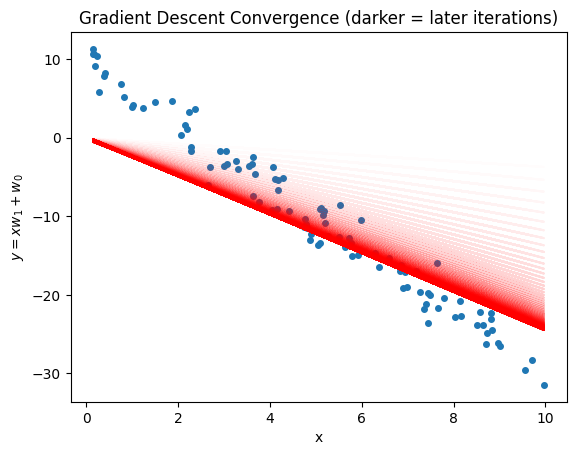

In [4]:
N = 100

# Generate N random x values uniformly distributed between 0 and 10
x = np.random.rand(N) * 10

# Create noisy linear data: y = -4x + 10 + noise
# True model: w_1 = -4 (slope), w_0 = 10 (intercept)
# np.random.randn(N) adds Gaussian noise with standard deviation 2
y = -4*x + 10 + 2*np.random.randn(N)

# Create optimizer with history recording enabled
# This allows us to visualize the optimization trajectory
optimizer = GradientDescent(learning_rate=.005, max_iters=100, record_history=True)

# Create and fit the model
model = LinearRegression()
model.fit(x, y, optimizer)

# Plot the data points
plt.plot(x, y, '.', label='data', markersize=8)

# Plot the model's predictions at each iteration of gradient descent
# This shows how the fitted line improves over time
for t, w in enumerate(optimizer.w_history):
    # w is shape (2,): w[0] is slope (w_1), w[1] is intercept (w_0)
    # Line equation: y = w[0]*x + w[1]
    # alpha increases with t: early iterations are more transparent
    # This creates a visual effect showing convergence
    plt.plot(x, x*w[0] + w[1], 'r-', alpha=t/len(optimizer.w_history), label=str(t))

plt.xlabel('x')
plt.ylabel(r'$y=xw_1 + w_0$')
plt.title('Gradient Descent Convergence (darker = later iterations)')

# Uncomment to zoom into specific regions
#plt.xlim(-20,20)
#plt.ylim(-100,100)

plt.show()

## Change of learning rate
Next, let's visualize the effect of learning rate on the behaviour of gradient descent in linear regression.
Again, we use the plot-contour function to visualize the optimization landscape. 

In [5]:
import itertools

def plot_contour(f, x1bound, x2bound, resolution, ax):
    """
    Plot contours of a 2D function f.
    
    This visualizes the cost landscape as a function of two parameters.
    Contour lines connect points with equal cost, like elevation lines on a map.
    
    Parameters:
    f: function that takes [param1, param2] and returns a scalar (the cost)
    x1bound: [min, max] for first parameter (e.g., w_0)
    x2bound: [min, max] for second parameter (e.g., w_1)
    resolution: number of grid points in each dimension
    ax: matplotlib axis to plot on
    
    Returns:
    ax: the axis with contours plotted
    """
    # Create 1D arrays of evenly spaced values for each parameter
    # x1range has 'resolution' points from x1bound[0] to x1bound[1]
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    
    # Create 2D grid: xg and yg are both (resolution x resolution) arrays
    # xg[i,j] contains the x1 value at grid point (i,j)
    # yg[i,j] contains the x2 value at grid point (i,j)
    # This creates all combinations of (x1, x2) parameter pairs
    xg, yg = np.meshgrid(x1range, x2range)
    
    # Initialize grid for function values (cost at each grid point)
    # zg will store the cost f([x1, x2]) at each point
    zg = np.zeros_like(xg)
    
    # Evaluate function f at each grid point
    # itertools.product gives all (i,j) combinations: (0,0), (0,1), ..., (res-1,res-1)
    for i, j in itertools.product(range(resolution), range(resolution)):
        # Compute cost for this parameter combination
        zg[i, j] = f([xg[i, j], yg[i, j]])
    
    # Draw contour lines: lines connecting points with equal cost
    # 100 contour levels creates a smooth visualization
    ax.contour(xg, yg, zg, 100)
    
    return ax

Let's track the steps of the 
gradient descent using different values for the learning rate.

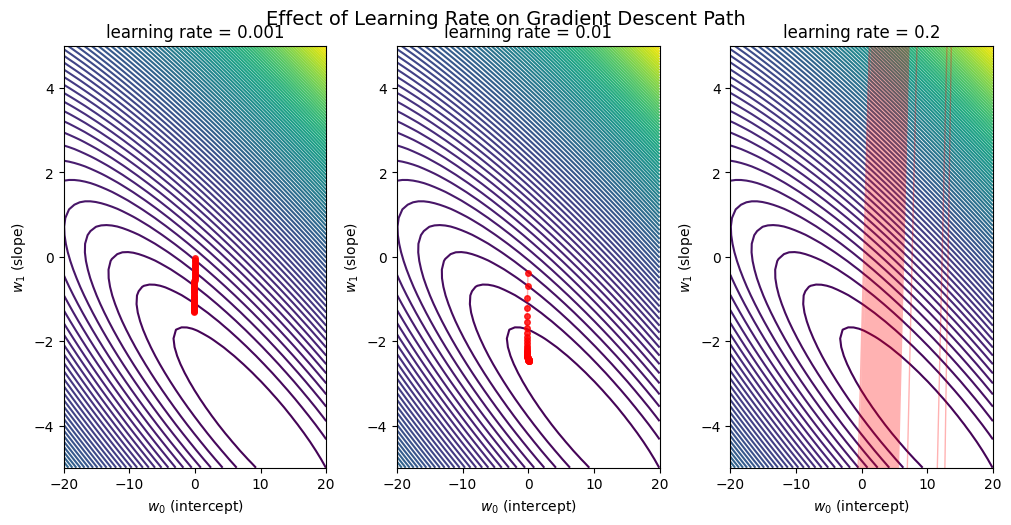

In [6]:
# Define the cost function (Mean Squared Error) as a function of weights w
# w[0] is the intercept (w_0), w[1] is the slope (w_1)
# Cost = 0.5 * mean((w_0 + w_1*x - y)^2)
# Broadcasting: w[1]*x is element-wise multiplication, shape (N,)
cost = lambda w: .5 * np.mean((w[0] + w[1]*x - y)**2)

# Test different learning rates to see their effect on optimization
learning_rates = [.001, .01, .2]

# Create side-by-side subplots, one for each learning rate
fig, axes = plt.subplots(ncols=len(learning_rates), nrows=1, constrained_layout=True, figsize=(10, 5))

# For each learning rate, run gradient descent and visualize the path
for i, lr in enumerate(learning_rates):
    # Create optimizer with current learning rate
    optimizer = GradientDescent(learning_rate=lr, max_iters=50, record_history=True)
    
    # Fit the model (this runs gradient descent)
    model = LinearRegression()
    model.fit(x, y, optimizer)
    
    # Plot the cost contours (the optimization landscape)
    # w_0 ranges from -20 to 20, w_1 ranges from -5 to 5
    plot_contour(cost, [-20, 20], [-5, 5], 50, axes[i])
    
    # Get the weight history and convert to array for easier indexing
    # w_hist has shape (num_iterations, 2) where each row is [w_1, w_0]
    # np.vstack stacks the list of 1D arrays into a 2D array
    w_hist = np.vstack(optimizer.w_history)
    
    # Plot the optimization path
    # w_hist[:,1] selects all rows, column 1 (w_0 values) - shape (num_iterations,)
    # w_hist[:,0] selects all rows, column 0 (w_1 values) - shape (num_iterations,)
    # Note: columns are swapped because w is stored as [w_1, w_0] but we plot (w_0, w_1)
    
    # Plot points at each iteration
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8, markersize=8)
    
    # Connect the points with lines to show the path
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3, linewidth=1)
    
    # Label the axes
    axes[i].set_xlabel(r'$w_0$ (intercept)')
    axes[i].set_ylabel(r'$w_1$ (slope)')
    axes[i].set_title(f'learning rate = {lr}')
    
    # Set consistent axis limits for comparison
    axes[i].set_xlim([-20, 20])
    axes[i].set_ylim([-5, 5])

plt.suptitle('Effect of Learning Rate on Gradient Descent Path', fontsize=14, y=1.02)
plt.show()

# Key observations:
# - Too small (0.001): slow, many iterations needed, path is nearly straight
# - Moderate (0.01): good balance, efficient convergence
# - Too large (0.2): oscillations, overshooting, inefficient zigzag path